In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from wordcloud import WordCloud, STOPWORDS

In [2]:
df_raw = pd.read_json('..//Datasets//Automotive_5.json', lines=True)
df_raw.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [3]:
# Let's read the first 5 reviews
for i in range(5):
    print('Review #{}: \n'.format(1+i), df_raw.reviewText[i], '\n\n')

Review #1: 
 I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though. 


Review #2: 
 These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks. 


Review #3: 
 Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nic

In [4]:
print('Null values in reviewText: \n{}'.format(df_raw.reviewText.isnull().sum()), '\n')
print('Null values in ratings: \n{}'.format(df_raw.overall.isnull().sum()), '\n')
df_raw.overall.value_counts()

Null values in reviewText: 
0 

Null values in ratings: 
0 



5    13928
4     3967
3     1430
2      606
1      542
Name: overall, dtype: int64

There is not really a clear cut way of determining a positive or negative sentiment from the data. There is no category for it like there was in the first sentiment analysis assignment. This leaves us with the tricky decision of engineering that feature from the data we have. I'd like to use the ratings but I'm not quite sure what to do with the neutral rating of '3'. Should we make a third class called neutral? Do we omit all ratings with '3'? Do we round up/down so that it is in a positive/negative class?

Let's explore those questions.

In [5]:
# First, let's make a few different x variables.
# Drop all ratings of three
df_drop_three = df_raw[df_raw['overall']!=3].copy()
X_drop = df_drop_three.loc[:, 'reviewText']
y_drop = np.where(df_drop_three.loc[:, 'overall']>3, 1, 0)

In [6]:
# Never used the following method before. What it does is makes a huge sparse matrix
# using each word as a feature. Let's try it, and hope my computer doesn't explode in the process
count_vect = CountVectorizer()
X_drop_counts = count_vect.fit_transform(X_drop)

# And now we can split the data
X_train, X_test, y_train, y_test = train_test_split(X_drop_counts, y_drop, test_size=0.2)

In [7]:
binary_clf = BernoulliNB()
binary_clf.fit(X_train, y_train)
y_pred = binary_clf.predict(X_test)
result_delete = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision, Recall, F1 Score: \n{}'.format(result_delete))
print(binary_clf.feature_count_)

Precision, Recall, F1 Score: 
(0.9480113636363636, 0.9308228730822873, 0.9393384940182969, None)
[[  6.   5.   1. ...   0.   2.   0.]
 [ 80. 147.   1. ...   1.   8.   1.]]


Wow, that was handled very nicely! It ran really fast and I'm happy with the scores we got. The feature importance, however, is useless unless we can get some labels for the word counts. Let's try the other ways for handling the neutral score and see how we do on those.

In [8]:
# Lets round 3 up to a positive sentiment
count_vect = CountVectorizer()
X_roundup = count_vect.fit_transform(df_raw.reviewText)
y_roundup = np.where(df_raw.overall>2, 1, 0)

# This will be important later
feature_names = count_vect.get_feature_names()

# And now we can split the data
X_train, X_test, y_train, y_test = train_test_split(X_roundup, y_roundup, test_size=0.2)

roundup_clf = BernoulliNB()
roundup_clf.fit(X_train, y_train)
y_pred = roundup_clf.predict(X_test)
result_roundup = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision, Recall, F1 Score: \n{}'.format(result_roundup))

Precision, Recall, F1 Score: 
(0.9505683320116309, 0.9304010349288486, 0.9403765690376568, None)


That was handled even better than the first attempt. The addition of more data must have helped. I have a feeling that since the extra data helped us to correctly classify positive examples, the sentiment of most '3' ratings is actually pretty positive. When we round down, this may negatively impact our results. Let's find out!

In [9]:
# Lets round 3 down to a negative sentiment
count_vect = CountVectorizer()
X_rounddown = count_vect.fit_transform(df_raw.reviewText)
y_rounddown = np.where(df_raw.overall>3, 1, 0)

# And now we can split the data
X_train, X_test, y_train, y_test = train_test_split(X_rounddown, y_rounddown, test_size=0.2)

rounddown_clf = BernoulliNB()
rounddown_clf.fit(X_train, y_train)
y_pred = rounddown_clf.predict(X_test)
result_rounddown = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision, Recall, F1 Score: \n{}'.format(result_rounddown))

Precision, Recall, F1 Score: 
(0.9006584597766962, 0.8746177370030581, 0.8874471086036672, None)


As expected, a rating of 3 is more closely related to a positive sentiment than a negative one. I like how easily interperatable the binary classifers are, and the prompt doesn't really care about finding "neutral" sentiments, so I will skip trying to classify the 3 ratings as their own class.

As the last attempt, I want to try to use our best classifier (roundup_clf) to use on another dataset. We will use the video games data, because I'm hoping this is very different from our automotive data.

In [10]:
df_videogames = pd.read_json('../Datasets/Video_Games_5.json', lines=True)
df_videogames.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


Good, looks like the data is in the same format. I'll just copy the roundup cell from above, change a few things, and just run it.

In [11]:
# First, round a rating of 3 up to a positive sentiment
y_roundup_videogames = np.where(df_videogames.overall>2, 1, 0)

# Next, we cannot simply plug in our new text into our old model. The X data must be the same shape
# as the data we used to fit the model. Otherwise we get an error. Luckily for us, we can use a list of 
# words as input to our CountVectorizer function. It will then only count the words we tell it to look for,
# and ignore all others. This should give us the exact same features as before.
count_vect = CountVectorizer(vocabulary=feature_names)
X_roundup_videogames = count_vect.fit_transform(df_videogames.reviewText)

In [12]:
print(X_roundup.shape)
X_roundup_videogames.shape

(20473, 27799)


(231780, 27799)

Yep, that worked! We have more examples, but the same number of features. Let's try it out on our pre-made classifier.

In [13]:
y_pred_videogames = roundup_clf.predict(X_roundup)
result_roundup_videogames = precision_recall_fscore_support(y_roundup, y_pred_videogames, average='binary')
print('Precision, Recall, F1 Score: \n{}'.format(result_roundup_videogames))

Precision, Recall, F1 Score: 
(0.9530865490339808, 0.9419404915912031, 0.9474807412034145, None)


Pretty amazing, our classifier actually did BETTER than with the original data. I think the reason for this is that there is simply more data.

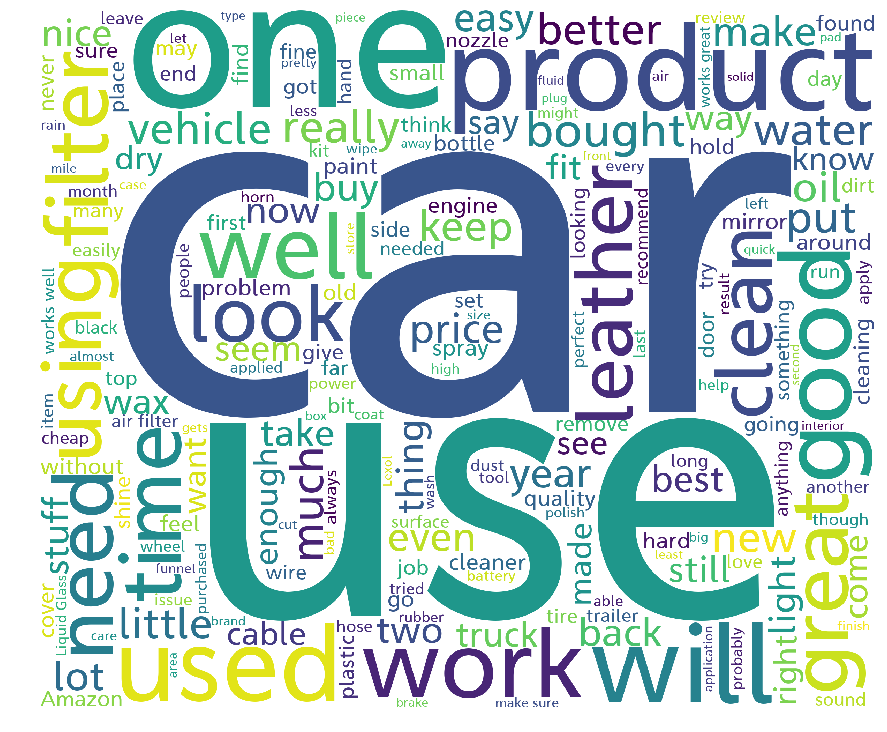

In [29]:
# Now let's make a word cloud. This wordcloud library takes one giant string of all
# of our text. It would be nice to just plug in our WordVect object but that's not the case.
positive_reviews = df_raw[df_raw['overall'] > 2]['reviewText'].copy()
word_string = ' '.join(positive_reviews[0:1000])

wordcloud = WordCloud(font_path='/Users/bretw/Desktop/Agane_roman.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=2400,
                      height=2000
                     ).generate(word_string)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
type(wordcloud)

wordcloud.wordcloud.WordCloud

In [21]:
# positive_reviews = df_raw[df_raw['overall'] > 2]['reviewText'].copy()
# ' '.join(positive_reviews)